Replicating the analysis in Beiró et al 2004 with a small twist :)


About the Datasets

    Date format:
    The hour column is computed by integer dividing the timestamp by 3600 seconds. 
    For example, the first line of the network for "noaltarifazo_ruidazonacional" 
    has hour=429531. 
    This means a timestamp of 429531*3600=1546311600 and it implies that the pair 
    of hashtags (h1, h2) was used in the hour comprised between timestamp 1546311600 
    and timestamp 1546315200, which corresponds to "1 January 2019 0:00:00 - 0:00:00". 
    The event itself was centered on 4 January 2019.


Exercise goal - replicate Figure 6(ish) 
- Create a network per hour where:
    Nodes are user and nodes connect when the same hashtags were used between user
- Calculate modularity (use networkix.community) and nestedness

## Load data and import Packages

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
import numpy as np
import networkx as nx
from networkx.algorithms import bipartite
from nestedness_master.nestedness_calculator import NestednessCalculator


from glob import glob
from tqdm import tqdm



In [30]:
# Data paths
n9_path = 'D:/FV/Personal/VIU/clean_data/9n_9ngranmarchaporlajusticia.csv'
noAlTar_path = 'D:/FV/Personal/VIU/clean_data/noaltarifazo_ruidazonacional.csv'

In [31]:
folder_path = 'D:/FV/Personal/VIU/clean_data/link_lists_after_cleaning/*bipartite*'

# folder_path = 'D:/FV/Personal/VIU/clean_data/bipartite_linkLists/*bipartite*'
files = glob(folder_path)

files = [f for f in files if '.csv' not in f]
file_path = files[0]

hour = file_path.split('_link_list.pickle')[0].split('_')[-2]
database = file_path.split('\\')[-1].split('_')[0]

with open(file_path, 'rb') as f:
    link_list = pickle.load(f)

hash_count = pd.DataFrame(link_list).groupby(1).size()
hash_only_used_by_one_user = hash_count[hash_count==1].index

clean_link_list = [link for link in link_list if link[1] not in hash_only_used_by_one_user]


complete_df = pd.DataFrame()

for file_path in tqdm(files):
    hour = file_path.split('_link_list.pickle')[0].split('_')[-2]
    database = file_path.split('\\')[-1].split('_')[0]

    with open(file_path, 'rb') as f:
        link_list = pickle.load(f)

    hash_count = pd.DataFrame(link_list).groupby(1).size()
    hash_only_used_by_one_user = hash_count[hash_count==1].index

    clean_link_list = [link for link in link_list if link[1] not in hash_only_used_by_one_user]

    clean_link_arr = np.array(clean_link_list)
    userNodes = np.unique(clean_link_arr[:,0])
    hashNodes = np.unique(clean_link_arr[:,1])

    nodes = np.concatenate([clean_link_arr[:,0], clean_link_arr[:,1]])

    G = nx.Graph()
    G.add_weighted_edges_from(clean_link_list)

    # Check if graph is bipartite
    is_bipartite = bipartite.is_bipartite(G)

    # Calculate modularity according to louvain method
    louvain_c = nx.community.louvain_communities(G)
    modularity = nx.community.modularity(G, louvain_c)

    # Calculate Nestedness
    mat = nx.adjacency_matrix(G, weight = 'None').todense()
    nestedness = NestednessCalculator(mat).nodf(mat)

    # get components
    components = sorted(nx.connected_components(G), key=len, reverse=True)
    nr_of_components = len(components)

    # Get database
    if database == '9n':
        db_df = pd.read_csv(n9_path)
        db_hour_df = db_df[db_df.hour == int(hour)]

    elif database == 'no':
        db_df = pd.read_csv(noAlTar_path)
        db_hour_df = db_df[db_df.hour == int(hour)]

    nr_of_unique_nodes_per_c = [len(c) for c in components]

    # Get nr of hashtag nodes
    total_nr_of_unique_hashs = len(hashNodes)

    # Get nr of user nodes
    total_nr_of_unique_user = len(userNodes)

    # Get total number of nodes
    total_nr_of_nodes = total_nr_of_unique_hashs + total_nr_of_unique_user

    # Get nr of hashtag nodes in giant component component
    total_nr_of_unique_hashs_gc = len([node for node in components[0] if str(node) in hashNodes])

    # Get nr of user nodes in giant component component
    total_nr_of_unique_user_gc = len([node for node in components[0] if str(node) in userNodes])

    # Get total number of nodes in giant component component
    total_nr_of_nodes_gc = total_nr_of_unique_hashs_gc + total_nr_of_unique_user_gc




    # Put Daa in Dataframe
    hour_df = pd.DataFrame([database, hour, modularity, nestedness, nr_of_components, 
                            total_nr_of_unique_hashs, total_nr_of_unique_user, total_nr_of_nodes,
                            total_nr_of_unique_hashs_gc, total_nr_of_unique_user_gc, total_nr_of_nodes_gc,
                            nr_of_unique_nodes_per_c,
                            is_bipartite]).T

    complete_df = pd.concat([complete_df, hour_df])


complete_df.columns = ['db', 'hour', 'mod', 'nest', 'n_comp', 
                       'total_nr_of_hashs', 'total_nr_of_users', 'total_nr_of_nodes' ,
                       'nr_of_hashs_in_giant_c', 'nr_of_users_in_giant_c', 'nr_of_nodes_in_giant_c',
                       'nr_of_unique_nodes_per_c',
                        'is_bipartite']

complete_df.to_csv('D:/FV/Personal/VIU/clean_data/graph_metrics_bipartite_trimed_clean.csv')
# complete_df.to_csv('D:/FV/Personal/VIU/clean_data/graph_metrics_bipartite_trimed.csv')

complete_df

100%|██████████| 357/357 [05:56<00:00,  1.00it/s]


,db,hour,mod,nest,n_comp,total_nr_of_hashs,total_nr_of_users,total_nr_of_nodes,nr_of_hashs_in_giant_c,nr_of_users_in_giant_c,nr_of_nodes_in_giant_c,nr_of_unique_nodes_per_c,is_bipartite
0,9n,436984,0.736525,0.028595,13,162,567,729,150,543,693,"[693, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]",True
0,9n,436985,0.716263,0.025294,13,207,805,1012,193,779,972,"[972, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3]",True
0,9n,436986,0.701251,0.029954,8,162,745,907,155,724,879,"[879, 8, 5, 3, 3, 3, 3, 3]",True
0,9n,436987,0.679844,0.031941,13,165,701,866,151,674,825,"[825, 6, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]",True
0,9n,436988,0.67606,0.029822,9,189,700,889,180,679,859,"[859, 5, 5, 4, 4, 3, 3, 3, 3]",True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,no,429786,0.726492,0.027492,10,89,234,323,75,211,286,"[286, 9, 5, 5, 3, 3, 3, 3, 3, 3]",True
0,no,429787,0.74724,0.019543,14,71,196,267,54,152,206,"[206, 13, 7, 7, 6, 4, 3, 3, 3, 3, 3, 3, 3, 3]",True
0,no,429788,0.690432,0.022909,13,96,198,294,73,156,229,"[229, 13, 12, 5, 5, 5, 4, 4, 4, 4, 3, 3, 3]",True
0,no,429789,0.733303,0.022738,15,88,169,257,58,129,187,"[187, 18, 6, 6, 5, 5, 5, 4, 3, 3, 3, 3, 3, 3, 3]",True


## Figure 6

In [22]:
graph_metrics_path = 'D:/FV/Personal/VIU/clean_data/graph_metrics_bipartite_trimed_clean.csv'
# graph_metrics_path = 'D:/FV/Personal/VIU/clean_data/graph_metrics_bipartite_trimed.csv'

graph_metrics_df = pd.read_csv(graph_metrics_path, index_col=0)

graph_metrics_df['date'] = pd.to_datetime(graph_metrics_df.hour * 3600, unit='s', 
                                          )

graph_metrics_df.head()

,db,hour,mod,nest,n_comp,total_nr_of_hashs,total_nr_of_users,total_nr_of_nodes,nr_of_hashs_in_giant_c,nr_of_users_in_giant_c,nr_of_nodes_in_giant_c,nr_of_unique_nodes_per_c,is_bipartite,date
0,9n,436984,0.734017,0.028595,13,162,567,729,150,543,693,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",True,2019-11-07 16:00:00
0,9n,436985,0.715990,0.025294,13,207,805,1012,193,779,972,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",True,2019-11-07 17:00:00
0,9n,436986,0.703901,0.029954,8,162,745,907,155,724,879,"[1, 1, 1, 1, 1, 1, 1, 1]",True,2019-11-07 18:00:00
0,9n,436987,0.679282,0.031941,13,165,701,866,151,674,825,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",True,2019-11-07 19:00:00
0,9n,436988,0.670659,0.029822,9,189,700,889,180,679,859,"[1, 1, 1, 1, 1, 1, 1, 1, 1]",True,2019-11-07 20:00:00


C:\Users\neuro\AppData\Local\Temp\ipykernel_18160\4173436846.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'high_modularity'] = 'no'


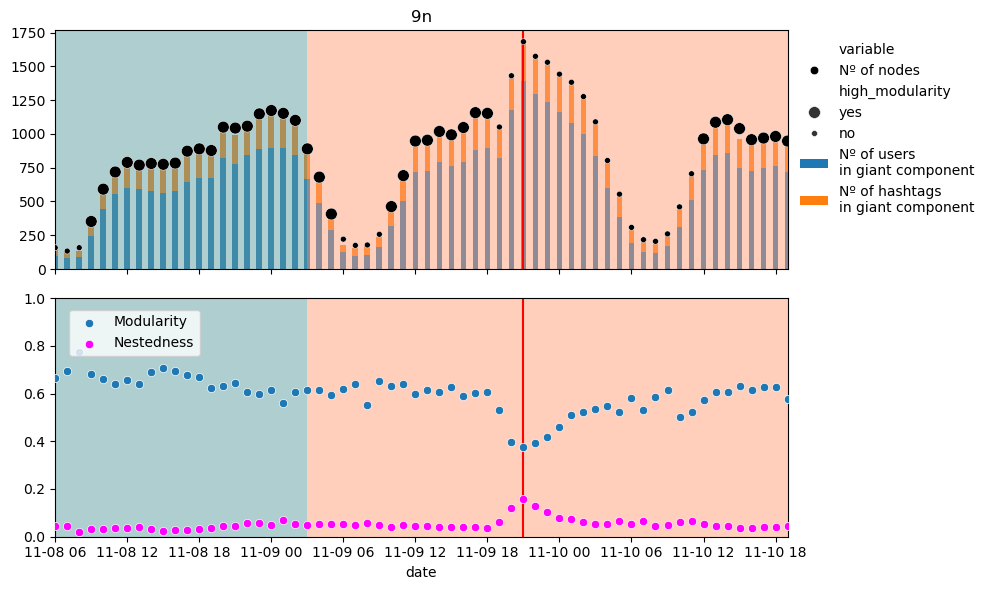

In [23]:
db = '9n'

df = graph_metrics_df.loc[(graph_metrics_df.db == db) & 
                             (graph_metrics_df.date <= '2019-11-10 19:00') & 
                             (graph_metrics_df.date >= '2019-11-08 06:00'), :]


def plot_figure6(df, db, total_users = True):

    fig, axes = plt.subplots(2,1, figsize = [10, 6],sharex=True)

    df.loc[:,'high_modularity'] = 'no'
    if total_users:
        df.loc[(df['mod'] > .55) & (df.total_nr_of_nodes > 0.2*df.total_nr_of_nodes.max()), 'high_modularity'] = 'yes'
    else:
        df.loc[(df['mod'] > .55) & (df.total_nr_of_nodes > 0.2*df.total_nr_of_nodes.max()), 'high_modularity'] = 'yes'

    df1 = df[['date', 'total_nr_of_nodes', 'high_modularity']].melt(id_vars = ['date', 'high_modularity'])
    df1['variable'] = df1.variable.replace({'nr_of_nodes_in_giant_c': 'Nº of nodes in\nthe giant component',
                                          'total_nr_of_nodes':  'Nº of nodes'})
    # Axis 0
    sns.scatterplot(data = df1, x = 'date', y = 'value', hue= 'variable', 
                    # style='high_modularity', style_order = ['yes', 'no'],
                    size = 'high_modularity', size_order = ['yes', 'no'],
                    palette = ['black',], zorder = 5, ax = axes[0])
    
    df2 = df[['date', 'nr_of_users_in_giant_c', 'nr_of_hashs_in_giant_c']]

    axes[0].bar(df2['date'], df2['nr_of_users_in_giant_c'], 
                color=sns.color_palette()[0], width=0.02, label = 'Nº of users\nin giant component')
    axes[0].bar(df2['date'], df2['nr_of_hashs_in_giant_c'], bottom=df2['nr_of_users_in_giant_c'], 
                color=sns.color_palette()[1], width=0.02, label = 'Nº of hashtags\nin giant component')
    axes[0].legend()
    sns.move_legend(
        axes[0], loc='upper left',
        bbox_to_anchor=(1, 1), ncol=1, title=None,
        frameon=False
    )

    # sns.scatterplot(data = df, x = 'date', y = 'nr_of_unique_hashs_in_giant_c', style='high_modularity', color = 'red', zorder = 5, ax = axes[0], label = 'Nº of hashtags in\nthe giant component')
    # sns.scatterplot(data = df, x = 'date', y = 'total_nr_of_unique_hashs', style='high_modularity', zorder = 5, color = 'black', ax = axes[0], label = 'Nº of hashtags')
    # Axis 1
    sns.scatterplot(data = df, x = 'date', y = 'mod', zorder = 5, ax = axes[1], label = 'Modularity')
    sns.scatterplot(data = df, x = 'date', y = 'nest', color = 'magenta', zorder = 5, ax = axes[1], label = 'Nestedness')
    # Add Axes spans and annotations
    if db == '9n':
        axes[0].axvline(x = pd.to_datetime('2019-11-09 21:00'), color = 'red')
        axes[0].axvspan(df.date.min(), '2019-11-09 03:00', facecolor='cadetblue', alpha=0.5)
        axes[0].axvspan('2019-11-09 03:00', df.date.max(), facecolor='lightsalmon', alpha=0.5)
        axes[0].set_xlim([df.date.min(), df.date.max() ]);
        # axes[0].legend(bbox_to_anchor=(0.01, 0.98), loc='upper left', )
        # ==========
        axes[1].axvline(x = pd.to_datetime('2019-11-09 21:00'), color = 'red')
        axes[1].axvspan(df.date.min(), '2019-11-09 03:00', facecolor='cadetblue', alpha=0.5)
        axes[1].axvspan('2019-11-09 03:00', df.date.max(), facecolor='lightsalmon', alpha=0.5)
        axes[1].set_xlim([df.date.min(), df.date.max() ]);
        axes[1].set_ylim([0,1]);
        axes[1].legend(bbox_to_anchor=(0.01, 0.98), loc='upper left', )
        for ax in axes:
            ax.set_ylabel('')
        axes[0].set_title('9n')

    elif db== 'no':
        axes[0].axvline(x = pd.to_datetime('2019-01-05 00:00'), color = 'red')
        axes[0].axvspan(df.date.min(), '2019-01-04 03:00', facecolor='cadetblue', alpha=0.5)
        axes[0].axvspan('2019-01-04 03:00', df.date.max(), facecolor='lightsalmon', alpha=0.5)
        axes[0].set_xlim([df.date.min(), df.date.max() ]);
        # axes[0].legend(bbox_to_anchor=(0.01, 0.98), loc='upper left', )
        # ==========
        axes[1].axvline(x = pd.to_datetime('2019-01-05 00:00'), color = 'red')
        axes[1].axvspan(df.date.min(), '2019-01-04 03:00', facecolor='cadetblue', alpha=0.5)
        axes[1].axvspan('2019-01-04 03:00', df.date.max(), facecolor='lightsalmon', alpha=0.5)
        axes[1].set_xlim([df.date.min(), df.date.max() ]);
        axes[1].set_ylim([0,1]);
        axes[1].legend(bbox_to_anchor=(0.01, 0.98), loc='upper left', )
        for ax in axes:
            ax.set_ylabel('')
        axes[0].set_title('No al tarifazo')
    
    plt.tight_layout()
    return fig, axes

fig, axes = plot_figure6(df, db, total_users=False)
plt.savefig('D:/FV/Personal/VIU/figures/f6_bipartite_9n_trimed_clean.png',transparent=True,bbox_inches='tight',pad_inches=0)
# plt.savefig('D:/FV/Personal/VIU/figures/f6_bipartite_9n_trimed.png',transparent=True,bbox_inches='tight',pad_inches=0)

# fig, axes = plot_figure6(df, db, total_users=True)
# plt.savefig('D:/FV/VIU/f6_userNodes_9n_totalHashs.png',transparent=True,bbox_inches='tight',pad_inches=0)

C:\Users\neuro\AppData\Local\Temp\ipykernel_18160\2437557142.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['high_modularity'] = 'low modularity'


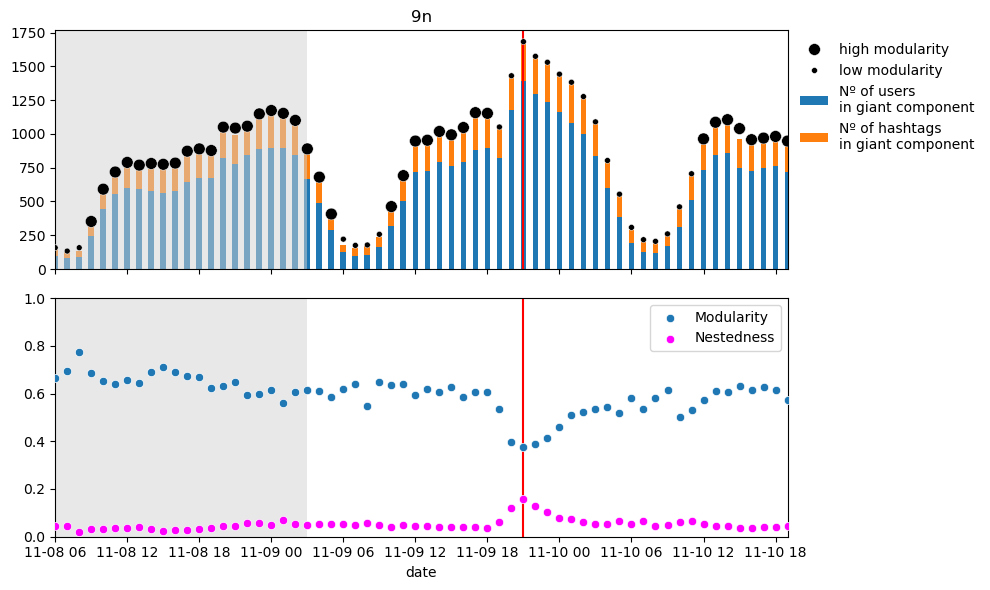

In [17]:
def plot_figure6(df, db, total_users=True):
    # Set up a 2-row plot, sharing the x-axis
    fig, axes = plt.subplots(2, 1, figsize=[10, 6], sharex=True)

    # Label high-modularity based on modularity score and number of nodes
    df['high_modularity'] = 'low modularity'
    threshold = 0.2 * df.total_nr_of_nodes.max()
    df.loc[(df['mod'] > 0.55) & (df.total_nr_of_nodes > threshold), 'high_modularity'] = 'high modularity'

    # Prepare data for plotting number of nodes, reshaping for easy plotting
    df1 = df[['date', 'total_nr_of_nodes', 'high_modularity']].melt(id_vars=['date', 'high_modularity'])
    df1['variable'] = df1['variable'].replace({
        'nr_of_nodes_in_giant_c': 'Nº of nodes in\nthe giant component',
        'total_nr_of_nodes': 'Nº of nodes'
    })

    # Plot total nodes and giant component size (Axis 0) with black markers
    sns.scatterplot(data=df1, x='date', y='value', size='high_modularity',
                    size_order=['high modularity', 'low modularity'],
                    color='black', zorder=5, ax=axes[0])

    # Stack bar chart for number of users and hashtags in the giant component
    df2 = df[['date', 'nr_of_users_in_giant_c', 'nr_of_hashs_in_giant_c']]
    axes[0].bar(df2['date'], df2['nr_of_users_in_giant_c'], color=sns.color_palette()[0], width=0.02,
                label='Nº of users\nin giant component')
    axes[0].bar(df2['date'], df2['nr_of_hashs_in_giant_c'], bottom=df2['nr_of_users_in_giant_c'],
                color=sns.color_palette()[1], width=0.02, label='Nº of hashtags\nin giant component')
    axes[0].legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False)

    # Plot modularity and nestedness values (Axis 1)
    sns.scatterplot(data=df, x='date', y='mod', zorder=5, ax=axes[1], label='Modularity')
    sns.scatterplot(data=df, x='date', y='nest', color='magenta', zorder=5, ax=axes[1], label='Nestedness')

    # Customize x-axis shading and labels based on dataset
    if db == '9n':
        date_cutoff = pd.to_datetime('2019-11-09 03:00')
        highlight_date = pd.to_datetime('2019-11-09 21:00')
        title = '9n'
    elif db == 'no':
        date_cutoff = pd.to_datetime('2019-01-04 03:00')
        highlight_date = pd.to_datetime('2019-01-05 00:00')
        title = 'No al tarifazo'
    
    # Apply light gray shading up to cutoff_date
    for ax in axes:
        ax.axvline(x=highlight_date, color='red')
        ax.axvspan(df.date.min(), date_cutoff, facecolor='lightgray', alpha=0.5)
        ax.set_xlim([df.date.min(), df.date.max()])
        ax.set_ylabel('')

    # Set y-axis limits and title for the second plot
    axes[1].set_ylim([0, 1])
    axes[0].set_title(title)

    plt.tight_layout()
    return fig, axes



fig, axes = plot_figure6(df, db, total_users=False)

C:\Users\neuro\AppData\Local\Temp\ipykernel_18160\2274256860.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['high_modularity'] = 'no'


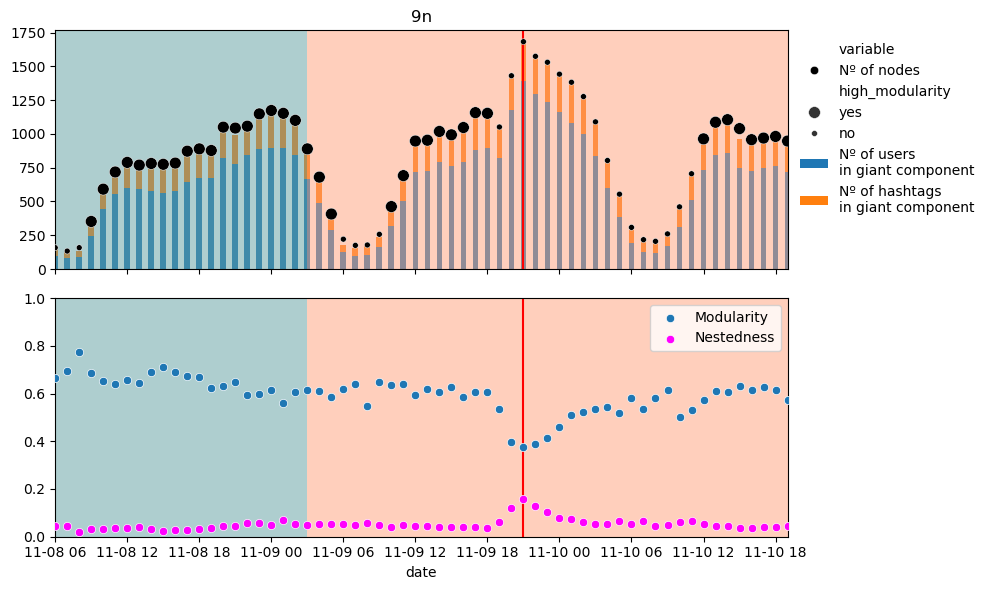

In [5]:
def plot_figure6(df, db, total_users=True):
    # Set up a 2-row plot, sharing the x-axis
    fig, axes = plt.subplots(2, 1, figsize=[10, 6], sharex=True)

    # Label high-modularity based on modularity score and number of nodes
    df['high_modularity'] = 'no'
    threshold = 0.2 * df.total_nr_of_nodes.max()
    df.loc[(df['mod'] > 0.55) & (df.total_nr_of_nodes > threshold), 'high_modularity'] = 'yes'

    # Prepare data for plotting number of nodes, reshaping for easy plotting
    df1 = df[['date', 'total_nr_of_nodes', 'high_modularity']].melt(id_vars=['date', 'high_modularity'])
    df1['variable'] = df1['variable'].replace({
        'nr_of_nodes_in_giant_c': 'Nº of nodes in\nthe giant component',
        'total_nr_of_nodes': 'Nº of nodes'
    })

    # Plot total nodes and giant component size (Axis 0)
    sns.scatterplot(data=df1, x='date', y='value', hue='variable', 
                    size='high_modularity', size_order=['yes', 'no'],
                    palette=['black'], zorder=5, ax=axes[0])

    # Stack bar chart for number of users and hashtags in the giant component
    df2 = df[['date', 'nr_of_users_in_giant_c', 'nr_of_hashs_in_giant_c']]
    axes[0].bar(df2['date'], df2['nr_of_users_in_giant_c'], color=sns.color_palette()[0], width=0.02,
                label='Nº of users\nin giant component')
    axes[0].bar(df2['date'], df2['nr_of_hashs_in_giant_c'], bottom=df2['nr_of_users_in_giant_c'],
                color=sns.color_palette()[1], width=0.02, label='Nº of hashtags\nin giant component')
    axes[0].legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False)

    # Plot modularity and nestedness values (Axis 1)
    sns.scatterplot(data=df, x='date', y='mod', zorder=5, ax=axes[1], label='Modularity')
    sns.scatterplot(data=df, x='date', y='nest', color='magenta', zorder=5, ax=axes[1], label='Nestedness')

    # Customize x-axis shading and labels based on dataset
    if db == '9n':
        date_cutoff = pd.to_datetime('2019-11-09 03:00')
        highlight_date = pd.to_datetime('2019-11-09 21:00')
        title = '9n'
    elif db == 'no':
        date_cutoff = pd.to_datetime('2019-01-04 03:00')
        highlight_date = pd.to_datetime('2019-01-05 00:00')
        title = 'No al tarifazo'
    
    # Apply highlighting and labeling for specified dates and limits
    for ax in axes:
        ax.axvline(x=highlight_date, color='red')
        ax.axvspan(df.date.min(), date_cutoff, facecolor='cadetblue', alpha=0.5)
        ax.axvspan(date_cutoff, df.date.max(), facecolor='lightsalmon', alpha=0.5)
        ax.set_xlim([df.date.min(), df.date.max()])
        ax.set_ylabel('')

    axes[1].set_ylim([0, 1])
    axes[0].set_title(title)

    plt.tight_layout()
    return fig, axes

fig, axes = plot_figure6(df, db, total_users=False)

C:\Users\neuro\AppData\Local\Temp\ipykernel_3776\4173436846.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'high_modularity'] = 'no'


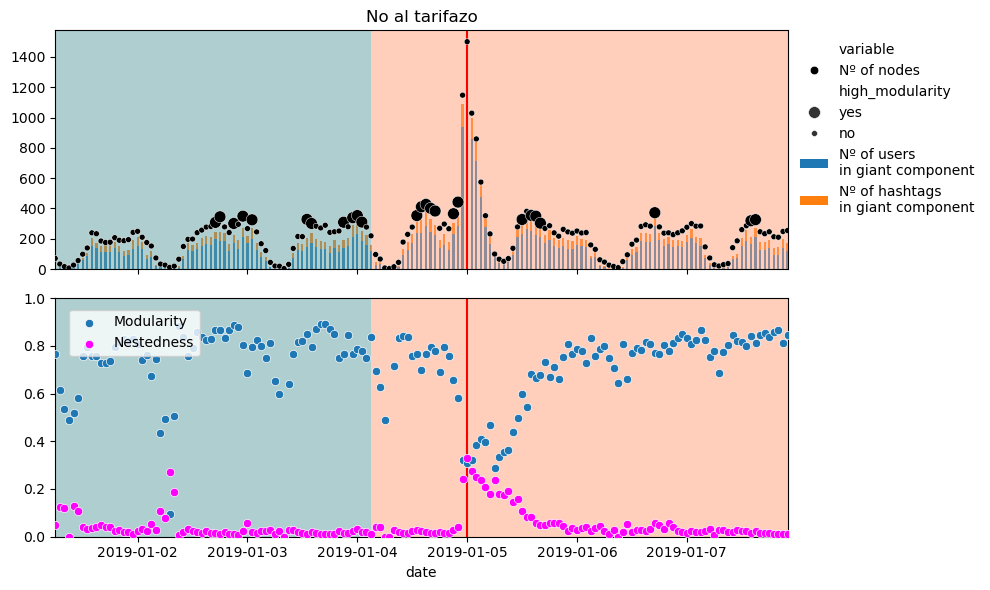

In [46]:

db = 'no'

df = graph_metrics_df.loc[(graph_metrics_df.db == db) & 
                             (graph_metrics_df.date >= '2019-01-01 06:00') & 
                             (graph_metrics_df.date <= '2019-01-07 22:00'), :]


fig, axes = plot_figure6(df, db, total_users=False)
plt.savefig('D:/FV/Personal/VIU/figures/f6_bipartite_no_al_tarifazo_trimed_clean.png',transparent=True,bbox_inches='tight',pad_inches=0)
# plt.savefig('D:/FV/Personal/VIU/figures/f6_bipartite_no_al_tarifazo_trimed.png',transparent=True,bbox_inches='tight',pad_inches=0)

# fig, axes = plot_figure6(df, db, total_users=True)
# plt.savefig('D:/FV/VIU/f6_userNodes_no_al_tarifazo_totalHashs.png',transparent=True,bbox_inches='tight',pad_inches=0)